# Parameter Estimation

Let's motivate this section with  the __Lotka-Volterra equations__, also known as the predator-prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact. The populations change through time according to the pair of equations:

$$
\dfrac{dx}{dt} = \alpha x - \beta xy \\
\dfrac{dy}{dt} = -\gamma y + \delta xy
$$

where
- $x$ is the number of prey;
- $y$ is the number of some predator;
- ${\tfrac {dy}{dt}}$ and ${\tfrac {dx}{dt}}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha$, $\beta$, $\gamma$ and $\delta$ are positive real parameters describing the interaction of the two species.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

from scipy.integrate import solve_ivp
from deepxde.backend import tf

Using backend: tensorflow.compat.v1

2023-02-24 23:32:50.176099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 23:32:50.254203: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 23:32:50.585630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/pinn/

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-02-24 23:32:51.147751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-24 23:32:51.161226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-24 23:32:51.161262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Train Data

The train data will be generated by ourserlves, so we will have a better understading of the error. Let's choose a time interval and parameters.

In [2]:
t_initial = 0
t_final = 10
x0 = 1.2
y0 = 0.8

In [3]:
alpha_real = 2 / 3
beta_real = 4 / 3
gamma_real = 1
delta_real = 1

In [4]:
def generate_data(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    return sol.y.T


In [5]:
t_train = np.linspace(t_initial, t_final, 100)
Y_train = generate_data(t_train, x0, y0, alpha_real, beta_real, gamma_real, delta_real)

## PINN

Now we will forget for a minute about the real values of $\alpha$, $\beta$, $\gamma$ and $\delta$ since the goal of this lesson is to learn how to estime these parameters. Let's start defining them in a way that our code knows they have to be learned.

In [6]:
# Pick some initial guess

alpha = dde.Variable(0.0)
beta = dde.Variable(0.0)
gamma = dde.Variable(0.0)
delta = dde.Variable(0.0)

Now we have to define the residuals and initial conditions in the same way the forward approximation (previous lecture).

In [7]:
def ode(t, Y):
    x = Y[:, 0:1]
    y = Y[:, 1:2]
    dx_dt = dde.grad.jacobian(Y, t, i=0)
    dy_dt = dde.grad.jacobian(Y, t, i=1)
    
    return [
        dx_dt - alpha * x + beta * x * y,
        dy_dt + gamma * y  - delta * x * y
    ]

In [8]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

def boundary(_, on_initial):
    return on_initial

ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

We can use the observed data `t_train` and `Y_train` for learning the values of our parameters. So we need to declare a new object and then include it to our model.

In [9]:
observe_x = dde.icbc.PointSetBC(t_train.reshape(-1, 1), Y_train[:, 0:1], component=0)
observe_y = dde.icbc.PointSetBC(t_train.reshape(-1, 1), Y_train[:, 1:2], component=1)

Be careful! Note that `component=0` is associated with the variable $x$ every time, defining the gradients, initial conditions and observed data. Same for `component=1` which corresponds to the variable $y$.

The data object is similar but we include the observed data as well in the list of conditions. But also note that we can add the observed data as train points with the argument `anchors`.

In [10]:
data = dde.data.PDE(
    geom,
    ode,
    [ic_x, ic_y, observe_x, observe_y],
    num_domain=3000,
    num_boundary=2,
    anchors=t_train.reshape(-1, 1),
    num_test = 5000,
)

Now we can define our neural network

In [11]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

## Training

This step is also similar, except we have to tell our model it has to learn external variables ($\alpha$, $\beta$, $\gamma$ and $\delta$).

In [12]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.001,
    external_trainable_variables=[alpha, beta, gamma, delta]
)
losshistory, train_state = model.train(iterations=30000)
model.compile("L-BFGS", external_trainable_variables=[alpha, beta, gamma, delta])
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.054338 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-02-24 23:32:52.341303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 23:32:52.342517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-24 23:32:52.342614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file t

'compile' took 0.883640 s

Initializing variables...
Training model...



2023-02-24 23:32:53.177061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-24 23:32:53.248229: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3148005460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-24 23:32:53.248262: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-02-24 23:32:53.254756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-24 23:32:53.437752: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-24 23:32:53.518284: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-02-24 23:

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.04e-02, 2.06e-03, 1.44e+00, 6.40e-01, 1.96e+00, 2.35e-01]    [1.03e-02, 2.04e-03, 1.44e+00, 6.40e-01, 1.96e+00, 2.35e-01]    []  
1000      [5.25e-03, 3.53e-03, 8.38e-05, 2.98e-05, 1.54e-03, 7.56e-04]    [5.26e-03, 3.53e-03, 8.38e-05, 2.98e-05, 1.54e-03, 7.56e-04]    []  
2000      [1.39e-04, 6.31e-05, 1.01e-06, 1.08e-06, 8.28e-05, 7.03e-05]    [1.39e-04, 6.30e-05, 1.01e-06, 1.08e-06, 8.28e-05, 7.03e-05]    []  
3000      [6.47e-05, 1.69e-05, 4.95e-08, 4.38e-06, 4.07e-05, 2.32e-05]    [6.43e-05, 1.68e-05, 4.95e-08, 4.38e-06, 4.07e-05, 2.32e-05]    []  
4000      [2.43e-04, 2.13e-04, 2.82e-06, 1.05e-05, 6.97e-04, 9.13e-05]    [2.43e-04, 2.13e-04, 2.82e-06, 1.05e-05, 6.97e-04, 9.13e-05]    []  
5000      [1.64e-04, 5.36e-05, 2.65e-05, 7.09e-07, 3.38e-04, 8.16e-05]    [1.64e-04, 5.34e-05, 2.65e-05, 7.09e-07, 3.38e-04, 8.16e-05] 

2023-02-24 23:33:48.563141: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                      Test loss                                                       Test metric
30000     [1.63e-06, 1.97e-06, 3.41e-07, 3.20e-12, 5.29e-06, 1.19e-06]    [1.64e-06, 1.95e-06, 3.41e-07, 3.20e-12, 5.29e-06, 1.19e-06]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000006
  Number of iterations: 9
  Number of functions evaluations: 48
30048     [1.18e-06, 1.49e-06, 8.32e-09, 1.85e-08, 2.03e-06, 1.16e-06]    [1.18e-06, 1.48e-06, 8.32e-09, 1.85e-08, 2.03e-06, 1.16e-06]    []  

Best model at step 30048:
  train loss: 5.89e-06
  test loss: 5.88e-06
  test metric: []

'train' took 1.370877 s



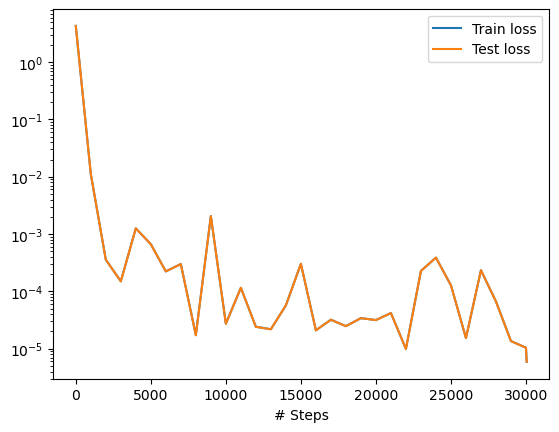

In [13]:
dde.utils.external.plot_loss_history(losshistory)

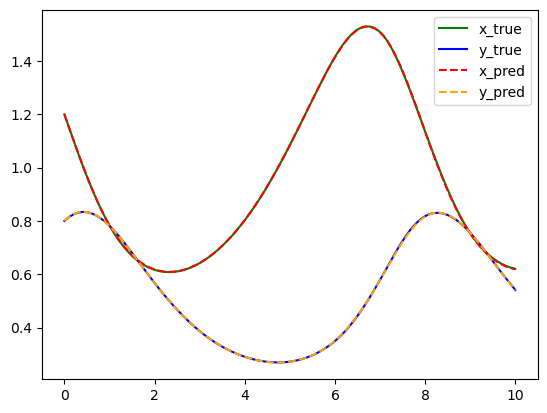

In [14]:
x_true = Y_train[:, 0:1]
y_true = Y_train[:, 1:2]
plt.plot(t_train, x_true, color="green", label="x_true")
plt.plot(t_train, y_true, color="blue", label="y_true")

sol_pred = model.predict(t_train.reshape(-1, 1))
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t_train, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t_train, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

$$(-\Delta)^{\alpha/2} u(x) = C(\alpha, D) \int_{||\theta||=1} D_\theta^\alpha u(x) d \theta$$